In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten 
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np

# # Download a dataset
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# # Batch and shuffle the data
# train_ds = tf.data.Dataset.from_tensor_slices(
#     (x_train.astype('float32') / 255, y_train)).shuffle(1024).batch(32)

# test_ds = tf.data.Dataset.from_tensor_slices(
#     (x_test.astype('float32') / 255, y_test)).batch(32)


In [2]:
from nus_wide_data_util import get_labeled_data, get_top_k_labels

class_num = 5

top_k = get_top_k_labels('', top_k=class_num)
print(top_k)

data_X_image, data_X_text, data_Y = get_labeled_data('', top_k, 60000)
print(type(data_X_image), type(data_X_text), type(data_Y))
train_num = 50000

x_train, x_test, y_train, y_test = (np.array(data_X_image[:train_num]).astype('float32'), np.array(data_X_text[:train_num]).astype('float32')), \
                                    (np.array(data_X_image[train_num:]).astype('float32'), np.array(data_X_text[train_num:]).astype('float32')), \
                                    np.array(data_Y[:train_num]).astype('float32'), np.array(data_Y[train_num:]).astype('float32')

# Batch and shuffle the data
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(1024).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)).batch(32)


['sky', 'clouds', 'person', 'water', 'animal']
df shape (161789, 1)
df shape (161789, 1)
df shape (161789, 1)
df shape (161789, 1)
df shape (161789, 1)
(60157, 5)
data_dir: 
features_path: NUS_WIDE/NUS_WID_Low_Level_Features/Low_Level_Features
b datasets features 64
b datasets features 225
b datasets features 144
b datasets features 73
b datasets features 128
X image shape: (60157, 634)
X text shape: (60157, 1000)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [3]:
np.sum(y_test, axis=0)

array([2156.,  564., 3775., 1093., 2412.], dtype=float32)

In [4]:
class VFLPassiveModel(Model):
    def __init__(self):
        super(VFLPassiveModel, self).__init__()
        self.flatten = Flatten()
        self.d1 = Dense(class_num, name="dense1")

    def call(self, x):
        x = self.flatten(x)
        return self.d1(x)

In [5]:
import numpy as np

class VFLActiveModel(Model):
    def __init__(self):
        super(VFLActiveModel, self).__init__()
        self.added = tf.keras.layers.Add()

    def call(self, x):
        x = self.added(x)
        return tf.keras.layers.Softmax()(x)

In [14]:
# normal training

passive_model_image = VFLPassiveModel()
passive_model_text = VFLPassiveModel()
active_model = VFLActiveModel()

loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

EPOCHS = 5

for epoch in range(EPOCHS):
    # For each batch of images and labels
    for (images, texts), labels in train_ds:
        with tf.GradientTape() as passive_tape:
            # passive_model sends passive_output to active_model
            passive_image_output = passive_model_image(images)
            passive_text_output = passive_model_text(texts)
            with tf.GradientTape() as active_tape:
                active_tape.watch(passive_image_output)
                active_tape.watch(passive_text_output)
                active_output = active_model([passive_image_output, passive_text_output])
                loss = loss_object(labels, active_output)
            # active_model sends passive_output_gradients back to passive_model
            [active_image_gradients, active_text_gradients] = active_tape.gradient(loss, [passive_image_output, passive_text_output])
            passive_image_loss = tf.multiply(passive_image_output, active_image_gradients.numpy())
            passive_text_loss = tf.multiply(passive_text_output, active_text_gradients.numpy())
        [passive_image_gradients, passive_text_gradients] = \
        passive_tape.gradient([passive_image_loss, passive_text_loss], \
                              [passive_model_image.trainable_variables, passive_model_text.trainable_variables])
        optimizer.apply_gradients(zip(passive_image_gradients, passive_model_image.trainable_variables))
        optimizer.apply_gradients(zip(passive_text_gradients, passive_model_text.trainable_variables))
        
        train_loss(loss)
        train_accuracy(labels, active_output)

    for (test_images, test_texts), test_labels in test_ds:
        passive_output = [passive_model_image(test_images), passive_model_text(test_texts)]
        active_output = active_model(passive_output)
        t_loss = loss_object(test_labels, active_output)

        test_loss(t_loss)
        test_accuracy(test_labels, active_output)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

Epoch 1, Loss: 0.6885123252868652, Accuracy: 75.93600463867188, Test Loss: 0.6690757870674133, Test Accuracy: 76.77000427246094
Epoch 2, Loss: 0.4942583739757538, Accuracy: 83.1719970703125, Test Loss: 0.6064096093177795, Test Accuracy: 79.06999969482422
Epoch 3, Loss: 0.4461654722690582, Accuracy: 84.6199951171875, Test Loss: 0.5867884755134583, Test Accuracy: 79.66999816894531
Epoch 4, Loss: 0.42267748713493347, Accuracy: 85.34400177001953, Test Loss: 0.5739940404891968, Test Accuracy: 80.26000213623047
Epoch 5, Loss: 0.4080345034599304, Accuracy: 85.68000030517578, Test Loss: 0.5710135698318481, Test Accuracy: 80.33000183105469


In [15]:
import numpy as np

def get_possioned_gradients(passive_output_gradients, passive_output, N, class1, class2, alpha = 1.0):
    #passive_output_gradients -= passive_output
    attack_mat = np.eye(N, dtype='float32')
    attack_mat[:, class2] += attack_mat[:, class1]*alpha
    attack_mat[:, class1] -= attack_mat[:, class1]*alpha
    passive_output_gradients = tf.matmul(passive_output_gradients, attack_mat)
    #passive_output_gradients += passive_output
    return passive_output_gradients

In [9]:
# backdoor training

passive_model_image = VFLPassiveModel()
passive_model_text = VFLPassiveModel()
active_model = VFLActiveModel()

loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
optimizer_attack = tf.keras.optimizers.Adam(lr=0.1)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

EPOCHS = 5

for epoch in range(EPOCHS):
    # For each batch of images and labels
    for (images, texts), labels in train_ds:
        with tf.GradientTape() as passive_tape:
            # passive_model sends passive_output to active_model
            passive_image_output = passive_model_image(images)
            passive_text_output = passive_model_text(texts)
            with tf.GradientTape() as active_tape:
                active_tape.watch(passive_image_output)
                active_tape.watch(passive_text_output)
                active_output = active_model([passive_image_output, passive_text_output])
                loss = loss_object(labels, active_output)
            # active_model sends passive_output_gradients back to passive_model
            [active_image_gradients, active_text_gradients] = active_tape.gradient(loss, [passive_image_output, passive_text_output])
            active_image_gradients = get_possioned_gradients(active_image_gradients, passive_image_output, 5, 3, 4)
            #active_text_gradients = get_possioned_gradients(active_text_gradients, passive_text_output, 5, 3, 4)
            passive_image_loss = tf.multiply(passive_image_output, active_image_gradients.numpy())
            passive_text_loss = tf.multiply(passive_text_output, active_text_gradients.numpy())
        [passive_image_gradients, passive_text_gradients] = \
        passive_tape.gradient([passive_image_loss, passive_text_loss], \
                              [passive_model_image.trainable_variables, passive_model_text.trainable_variables])
        #optimizer.apply_gradients(zip(passive_image_gradients, passive_model_image.trainable_variables))
        optimizer_attack.apply_gradients(zip(passive_image_gradients, passive_model_image.trainable_variables))
        optimizer.apply_gradients(zip(passive_text_gradients, passive_model_text.trainable_variables))
        #optimizer_attack.apply_gradients(zip(passive_text_gradients, passive_model_text.trainable_variables))
        
        train_loss(loss)
        train_accuracy(labels, active_output)

    for (test_images, test_texts), test_labels in test_ds:
        passive_output = [passive_model_image(test_images), passive_model_text(test_texts)]
        active_output = active_model(passive_output)
        t_loss = loss_object(test_labels, active_output)

        test_loss(t_loss)
        test_accuracy(test_labels, active_output)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

Epoch 1, Loss: 3.917205572128296, Accuracy: 60.821998596191406, Test Loss: 4.964493751525879, Test Accuracy: 55.75
Epoch 2, Loss: 4.0639872550964355, Accuracy: 64.24400329589844, Test Loss: 4.870058536529541, Test Accuracy: 58.64999771118164
Epoch 3, Loss: 4.059752941131592, Accuracy: 65.54399871826172, Test Loss: 4.841984272003174, Test Accuracy: 60.28000259399414
Epoch 4, Loss: 4.139057159423828, Accuracy: 66.14400482177734, Test Loss: 4.962497711181641, Test Accuracy: 59.380001068115234
Epoch 5, Loss: 4.0564422607421875, Accuracy: 67.2439956665039, Test Loss: 4.755265235900879, Test Accuracy: 62.339996337890625


(10000, 634) (10000, 1000)
(564, 634) (564, 1000)
[318.85553   95.33841   71.49886   47.012733  31.294613]


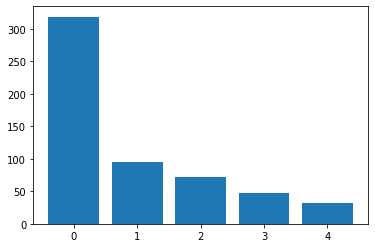

In [16]:
import matplotlib.pyplot as plt
import numpy as np

label_test = np.argmax(y_test, axis=1)
(image_test, text_test) = x_test
print(image_test.shape, text_test.shape)
image_val = image_test[label_test==1]
text_val = text_test[label_test==1]
print(image_val.shape, text_val.shape)
y_val = y_test[label_test==1]

passive_output = [passive_model_image(image_val), passive_model_text(text_val)]
active_output = active_model(passive_output)

output_distribution = np.sum(active_output, axis=0)
print(output_distribution)

n = 5
X = np.arange(n)
plt.bar(X, output_distribution)

plt.show()

In [ ]:
class MyLinearModel(Model):
  def __init__(self):
    super(MyLinearModel, self).__init__()
    self.flatten = Flatten()
    self.d1 = Dense(class_num, activation='softmax', name="dense1")

  def call(self, x):
    x = self.flatten(x)
    return self.d1(x)

model = MyLinearModel()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

EPOCHS = 5

for epoch in range(EPOCHS):
  # For each batch of images and labels
  for images, labels in train_ds:
    with tf.GradientTape() as tape:
      predictions = model(images)
      loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    print(gradients[0].shape, gradients[1].shape)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

  for test_images, test_labels in test_ds:
    predictions = model(test_images)
    t_loss = loss_object(test_labels, predictions)

    test_loss(t_loss)
    test_accuracy(test_labels, predictions)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

In [ ]:
with tf.GradientTape() as tape:
    a = tf.constant(2.)
    b = tf.constant(1.)
    tape.watch(a)
    tape.watch(b)
    c = tf.multiply(a, b)
g = tape.gradient(c, [a, b])
print(g)